# Densenet121

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random

In [3]:
import cv2
import matplotlib.pyplot as plt 

In [4]:
PATH = Path("/home/ubuntu/data/sandwich/")

In [5]:
# list(PATH.iterdir())

In [6]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# Data augmentation

In [7]:
import math
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]


# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

# Train-validation split

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
def get_files(path):
    paths = [d for d in list(path.iterdir()) if d.is_dir()]
    files = [f for d in paths for f in list(d.iterdir())]
    return files

In [10]:
path = PATH/"train-315"

In [11]:
files = get_files(path)

In [12]:
# files

In [13]:
file_labels = [p.parts[-2] for p in files]

In [14]:
train_files, valid_files, y_train, y_valid = train_test_split(files, file_labels, test_size=0.2, random_state=42)

In [15]:
# from collections import Counter

In [16]:
# Counter(y_train), Counter(y_valid)

# Dataset

In [17]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [18]:
paths = [d for d in list(path.iterdir()) if d.is_dir()]

In [19]:
labels = [p.parts[-1] for p in paths]

In [20]:
labels

['hot_dog',
 'pulled_pork_sandwich',
 'grilled_cheese_sandwich',
 'lobster_roll_sandwich',
 'hamburger',
 'club_sandwich']

In [21]:
class SandwichDataset(Dataset):
    def __init__(self, files, labels, transforms=False):
        self.files = files
        self.label2ind = {v:k for k,v in enumerate(labels)}
        self.transforms = transforms
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        path = self.files[idx]
        name = path.parts[-1]
        y_class = self.label2ind[path.parts[-2]]
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
        if self.transforms:
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            if np.random.random() > 0.5: x = np.fliplr(x).copy()
            x = random_crop(x)
        else:
            x = center_crop(x)
        x = normalize(x)
        y = self.label2ind[path.parts[-2]]
        return np.rollaxis(x, 2), y

In [22]:
train_ds = SandwichDataset(files=train_files, labels=labels, transforms=True)

In [23]:
valid_ds = SandwichDataset(files=valid_files, labels=labels, transforms=False)

In [24]:
# len(train_ds), len(valid_ds)

In [25]:
x, y = train_ds[0]

In [26]:
# x.shape, y

In [27]:
batch_size = 25

In [28]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [29]:
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

In [30]:
x, y = next(iter(train_dl))

In [31]:
x = x.cuda().float()
y = y.cuda()

In [32]:
# x.shape, y.shape

In [33]:
# y.shape[0]

# Initialize pre-trained model with frozen hidden layers

In [34]:
densenet = models.densenet121(pretrained=True)

In [35]:
layers = list(densenet.children())

In [36]:
print(len(layers))

2


In [37]:
# layers[0]

In [38]:
densenet.classifier

Linear(in_features=1024, out_features=1000, bias=True)

In [39]:
class Densenet(nn.Module):
    def __init__(self):
        super(Densenet, self).__init__()
        self.model = models.densenet121(pretrained=True)
        # freezing parameters
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.classifier = nn.Linear(1024, 6)
    
    def forward(self, x):
        x = self.model(x)
        return x

In [40]:
model = Densenet().cuda()

In [41]:
out = model(x)

In [42]:
# out

In [43]:
# _, pred = torch.max(out, 1)

In [44]:
# pred

In [45]:
# y

In [46]:
# pred.eq(y).sum()

In [47]:
F.cross_entropy(out, y).item()

1.7797839641571045

# Compute accuracy

In [48]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y in valid_dl:
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda()
        out = model(x)
        _, pred = torch.max(out, 1)
        correct += pred.eq(y).sum().item()
        loss = F.cross_entropy(out, y)
        sum_loss += batch*(loss.item())
        total += batch
    return sum_loss/total, correct/total

In [49]:
# val_metrics(model, valid_dl)

# Train model with fixed learning rate for 10 epochs

In [50]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [51]:
model_path = Path("/home/ubuntu/models/sandwich/")

In [65]:
def get_optimizer(model, lr=0.01, wd=0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [52]:
def train(model, epochs=5, learning_rate=0.01):
    optimzer = get_optimizer(model, lr=learning_rate, wd=0)
    prev_val_acc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y in train_dl:
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            _, pred = torch.max(out, 1)
            loss = F.cross_entropy(out, y)
            optimzer.zero_grad()
            loss.backward()
            optimzer.step()
            total += batch
            sum_loss += batch*(loss.item())
        val_loss, val_acc = val_metrics(model, valid_dl)
        if i % 2 == 0:
            print("train loss %.3f val loss %.3f val accuracy %.3f" % (sum_loss/total, val_loss, val_acc))
        if val_acc > prev_val_acc:
            prev_val_acc = val_acc
            if val_acc > 0.6:
                path = "{0}/initial_densenet_{1:.0f}.pth".format(model_path, 100*val_acc)
                save_model(model, path)
                print(path)

In [53]:
model = Densenet().cuda()

In [54]:
train(model, epochs=10, learning_rate=0.01)

train loss 1.599 val loss 0.771 val accuracy 0.718
/home/ubuntu/models/sandwich/initial_densenet_72.pth
/home/ubuntu/models/sandwich/initial_densenet_74.pth
train loss 0.732 val loss 0.751 val accuracy 0.731
/home/ubuntu/models/sandwich/initial_densenet_75.pth
train loss 0.680 val loss 0.752 val accuracy 0.741
train loss 0.677 val loss 0.816 val accuracy 0.719
train loss 0.644 val loss 0.774 val accuracy 0.749
/home/ubuntu/models/sandwich/initial_densenet_76.pth


In [55]:
# save_model(model, model_path/"initial_densennet.pth")

# Learning rate range test

In [53]:
def LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=0.1, epochs=5):
    losses = []
    p = model_path/"resnet_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    optimizer = get_optimizer(model, lr=lrs[0], wd=0.0)
    for i in range(epochs):
        for x, y in train_dl:
            update_optimizer(optimizer, lr=lrs[ind])
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            ind += 1
            
    load_model(model, str(p))
    return lrs, losses

In [54]:
model = Densenet().cuda()

In [55]:
lrs, losses = LR_range_finder(model, train_dl)

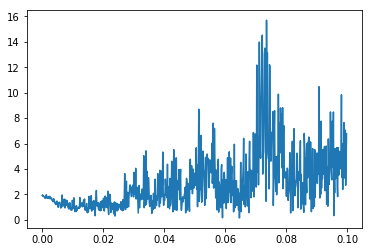

In [56]:
plt.plot(lrs, losses)
plt.show()

# Train linear layer with 1-cycle triangular learning rate for 30 epochs

In [57]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

In [66]:
def train_triangular_policy2(model, train_dl, valid_dl, max_lr=0.03, epochs=10):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = get_optimizer(model, lrs[0])
    prev_val_acc = 0.0
    ind = 0
    for j in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            lr = lrs[idx]
            update_optimizer(optimizer, lr=lrs[ind])
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.item())
            ind += 1
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.76:
                path = "{0}/ft_densenet_{1:.0f}.pth".format(model_path, 100*val_acc)
                save_model(model, path)
                print(path)
    return sum_loss/total

In [59]:
model = Densenet().cuda()

In [60]:
val_metrics(model, valid_dl)

(1.9726057185067072, 0.15555555555555556)

In [67]:
train_triangular_policy2(model, train_dl, valid_dl, max_lr=0.03, epochs=30)

train_loss 1.331 val_loss 0.935 val_acc 0.678
train_loss 0.929 val_loss 0.823 val_acc 0.710
train_loss 0.872 val_loss 0.948 val_acc 0.664
train_loss 0.920 val_loss 1.133 val_acc 0.648
train_loss 1.087 val_loss 1.159 val_acc 0.680
train_loss 1.193 val_loss 0.998 val_acc 0.726
train_loss 1.343 val_loss 1.813 val_acc 0.666
train_loss 1.668 val_loss 2.498 val_acc 0.630
train_loss 1.724 val_loss 2.676 val_acc 0.651
train_loss 1.723 val_loss 2.137 val_acc 0.684
train_loss 1.517 val_loss 2.470 val_acc 0.694
train_loss 1.968 val_loss 1.625 val_acc 0.740
train_loss 1.732 val_loss 2.370 val_acc 0.698
train_loss 1.818 val_loss 2.839 val_acc 0.647
train_loss 1.313 val_loss 2.383 val_acc 0.674
train_loss 1.626 val_loss 2.442 val_acc 0.682
train_loss 1.814 val_loss 1.667 val_acc 0.727
train_loss 1.320 val_loss 2.128 val_acc 0.712
train_loss 1.139 val_loss 1.566 val_acc 0.750
train_loss 1.089 val_loss 1.776 val_acc 0.721
train_loss 0.993 val_loss 1.807 val_acc 0.712
train_loss 0.932 val_loss 1.598 va

0.6140875641463531